In [1]:
import sys
import torch
import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from math import floor

from torch.utils.data import SubsetRandomSampler

import torch.nn.functional as F

sys.path.append("../")
from net import MNISTNet

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size=128
seed = 12131415

# Download and load the training data
training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

train_size = len(training_set)
valid_size = 0.2
split_point = int(floor(valid_size * train_size))
indices = list(range(train_size))

tr_idx, vl_idx = indices[split_point:], indices[:split_point]

tr_sampler = SubsetRandomSampler(tr_idx, generator = torch.Generator().manual_seed(seed))
vl_sampler = SubsetRandomSampler(vl_idx, generator = torch.Generator().manual_seed(seed))

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, sampler=tr_sampler)
validation_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, sampler=vl_sampler)



In [3]:
device = 'cpu'
net = MNISTNet(device=device,dtype=torch.float64)
net.load_state_dict(torch.load("./models/mnist/student", map_location=device))


<All keys matched successfully>

In [88]:
def compute_accuracy(loader):
    net.eval()
    running_loss = 0.0
    for (i, data) in enumerate(loader):
        x, y = data
        x = x.to(device).to(torch.float64)
        preds = net(x)
        running_loss += (y == F.softmax(preds.cpu(), 1).max(1)[1]).to(torch.int64).sum().item()
    return running_loss
print("Accuracy on Training:", compute_accuracy(training_loader) / len(tr_idx))    
print("Accuracy on Validation:", compute_accuracy(validation_loader) / len(vl_idx))    
print("Accuracy on Test:", compute_accuracy(test_loader) / len(test_set))    

Accuracy on Training: 0.9878958333333333
Accuracy on Validation: 0.98275
Accuracy on Test: 0.9825


In [4]:
x = test_set.data[0].to(torch.float64)

x


tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,

In [116]:
X  = test_set.data[:2].view(2, 1, 28, 28).to(torch.float64)
y = test_set.targets
net = net.to('cpu')

preds = net(X)


In [117]:
X.shape

torch.Size([2, 1, 28, 28])

In [118]:
v = (0.2 * torch.rand(5, 28 * 28) )
W = ((X.view(-1, 28 * 28).repeat(v.shape[0], 1) + v.repeat_interleave(X.shape[0], dim=0)).tanh() + 1) / 2
print(W.shape)

torch.Size([10, 784])


In [119]:
preds = F.softmax(net(W.view(-1, 1, 28, 28)), dim=1)

In [121]:
preds.shape

torch.Size([10, 10])

In [125]:
test_set.targets[:1].repeat(1).view(-1, 1)

tensor([[7]])

In [115]:

p1 = preds.gather(1, test_set.targets[:2].repeat(v.shape[0]).view(-1, 1)).view(v.shape[0], -1).log() 
print(test_set.targets.shape)
mask = torch.ones_like(preds, dtype=torch.bool)
mask[torch.arange(mask.shape[0]), test_set.targets[:2].repeat(v.shape[0]).view(-1)] = False

p2 = preds[mask].view(mask.shape[0], -1).log().max(1)[0].view(v.shape[0], -1)

ris = torch.maximum(p1 - p2, torch.zeros_like(p1))

print(ris.mean(dim=1, keepdim=True))

#print(p2)
#pz = torch.zeros_like(pp)
#torch.maximum(preds.gather(1, test_set.targets.repeat(v.shape[0]).view(-1, 1)).view(3, -1).log() - preds.log().max(dim=1)[0].view(3, -1), pz) #- preds.log().max(dim=1)[0].view(3, -1)

torch.Size([10000])
tensor([[137.6789],
        [139.5912]], dtype=torch.float64, grad_fn=<MeanBackward1>)


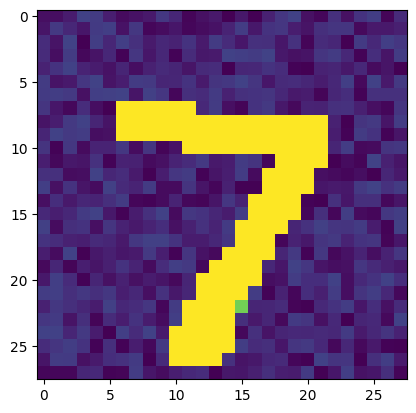

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(W[0].view(28, 28))

Original:  9
Modified:  9


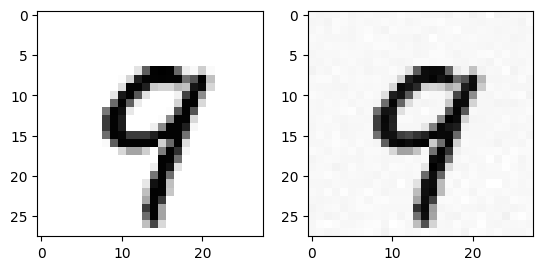

In [37]:
import matplotlib.pyplot as plt

x  = test_set.data[12]
net = net.to('cpu')
print("Original: ", F.softmax(net(x.view(1, 1, 28, 28).to(torch.float32)), 1).max(1)[1].item())

v =  5 * torch.randn(28 * 28)

w = (x.view(-1) + v).view(28, 28)
print("Modified: ", F.softmax(net(w.view(1, 1, 28, 28).to(torch.float32)), 1).max(1)[1].item())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x.view(28,28), cmap='Grays')
ax2.imshow(w, cmap='Grays')

In [104]:
def get_data_by_label(data_set, label):
    indices = torch.argwhere(data_set.targets == label)
    return data_set.data[indices, :, :],data_set.targets[indices] 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size=128
seed = 12131415

training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


print("[--] Network loaded!")

X, Y = get_data_by_label(training_set, 0)

print(X.shape)

[--] Network loaded!
torch.Size([5923, 1, 28, 28])


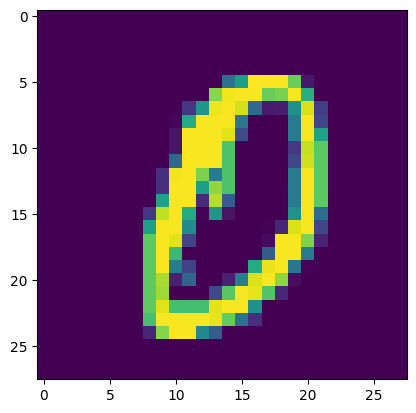

In [106]:

fig, ax = plt.subplots()
ax.imshow(X[920].view(28, 28))